In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torch import nn, optim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torchvision.datasets import ImageFolder
from sklearn.metrics import classification_report, confusion_matrix
import os

In [3]:
transform = transforms.Compose([transforms.Resize((100, 100)),transforms.ToTensor()])
DATA_DIR = r"Rock Paper Scissors/train"
dataset = ImageFolder(root=DATA_DIR, transform=transform)
class_names = dataset.classes

print("Classes:", class_names)
print("Total images:", len(dataset))

Classes: ['paper', 'rock', 'scissors']
Total images: 2520


In [4]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

In [5]:
class RPSClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 12 * 12, 128), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(128, 3)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

model = RPSClassifier()

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
EPOCHS = 10

In [7]:
train_losses, val_losses = [], []

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")


Epoch 1/10 - Train Loss: 0.6709, Val Loss: 0.0755
Epoch 2/10 - Train Loss: 0.0452, Val Loss: 0.0093
Epoch 3/10 - Train Loss: 0.0065, Val Loss: 0.0030
Epoch 4/10 - Train Loss: 0.0044, Val Loss: 0.0015
Epoch 5/10 - Train Loss: 0.0009, Val Loss: 0.0003
Epoch 6/10 - Train Loss: 0.0013, Val Loss: 0.0012
Epoch 7/10 - Train Loss: 0.0005, Val Loss: 0.0001
Epoch 8/10 - Train Loss: 0.0002, Val Loss: 0.0000
Epoch 9/10 - Train Loss: 0.0001, Val Loss: 0.0000
Epoch 10/10 - Train Loss: 0.0002, Val Loss: 0.0000


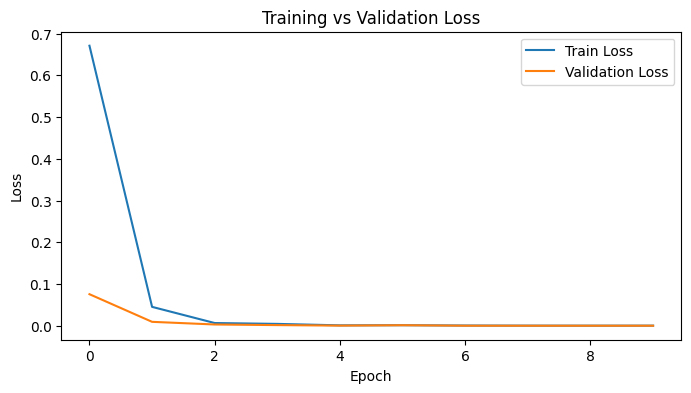

In [8]:
plt.figure(figsize=(8,4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

In [9]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in val_loader:
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds.numpy())

In [10]:
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

       paper       1.00      1.00      1.00       175
        rock       1.00      1.00      1.00       146
    scissors       1.00      1.00      1.00       183

    accuracy                           1.00       504
   macro avg       1.00      1.00      1.00       504
weighted avg       1.00      1.00      1.00       504



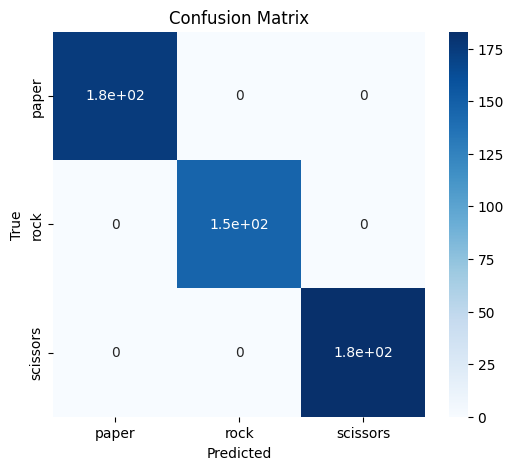

In [11]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()